# EDA
## Import necessary libraries 

In [180]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np
import requests
from io import StringIO
import nfl_data_py as nfl

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Load the data from digital ocean

In [181]:
# Define the base path and URLs as per your config file
BASE_CDN_PATH = "https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com"
TRACKING_DATA_URL_TEMPLATE = BASE_CDN_PATH + "/raw/tracking_data/tracking_week_{week}.csv"
PLAYS_URL = BASE_CDN_PATH + "/raw/plays.csv"
GAMES_URL = BASE_CDN_PATH + "/raw/games.csv"
PLAYERS_URL = BASE_CDN_PATH + "/raw/players.csv"
COLORS_URL = BASE_CDN_PATH + "/raw/colors.csv"
TACKLES_URL = BASE_CDN_PATH + "/raw/tackles.csv"

# Replace 'week' with the actual week number you want to download
week_number = 1
TRACKING_DATA_URL = TRACKING_DATA_URL_TEMPLATE.format(week=week_number)

# Define a function to download and return a DataFrame
def download_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Assuming the data is in CSV format
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to download data from {url}")
        return None


# Download the data
tracking_data = download_data(TRACKING_DATA_URL)
plays_data = download_data(PLAYS_URL)
players_data = download_data(PLAYERS_URL)
colors_data = download_data(COLORS_URL)
tackles_data = download_data(TACKLES_URL)
games_data = download_data(GAMES_URL) 

In [182]:
print(tracking_data.info())
print(plays_data.info())
print(players_data.info())
print(colors_data.info())
print(tackles_data.info())
print(games_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407439 entries, 0 to 1407438
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         1407439 non-null  int64  
 1   playId         1407439 non-null  int64  
 2   nflId          1346246 non-null  float64
 3   displayName    1407439 non-null  object 
 4   frameId        1407439 non-null  int64  
 5   time           1407439 non-null  object 
 6   jerseyNumber   1346246 non-null  float64
 7   club           1407439 non-null  object 
 8   playDirection  1407439 non-null  object 
 9   x              1407439 non-null  float64
 10  y              1407439 non-null  float64
 11  s              1407439 non-null  float64
 12  a              1407439 non-null  float64
 13  dis            1407439 non-null  float64
 14  o              1346397 non-null  float64
 15  dir            1346397 non-null  float64
 16  event          130268 non-null   object 
dtypes: float

## Load DATA from pipeline

In [183]:
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1_completions_only_run2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Loop through weeks 2 to 9
for week in range(1, 10):
    # Construct file path for the current week
    file_path = f'/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_{week}_completions_only_run2.csv'
    
    # Read the data
    week_df = pd.read_csv(file_path)
    
    # Remove any unnamed columns
    week_df = week_df.loc[:, ~week_df.columns.str.contains('^Unnamed')]
    
    # Append to the original DataFrame
    df = pd.concat([df, week_df], ignore_index=True)


In [184]:
df.columns

Index(['nflId', 'frechet_distance', 'play_id', 'game_id', 'week_num',
       'displayName', 'position', 'gameId', 'playId', 'passResult',
       'expectedPointsAdded', 'defensiveTeam'],
      dtype='object')

In [185]:
#sanity check
plays_per_game = df.groupby('game_id')['play_id'].nunique()

# Calculating the average number of plays per game
average_plays_per_game = plays_per_game.mean()
average_plays_per_game

41.4921875

In [186]:
# Merge the DataFrames on 'playId' and 'nflId'
merged_df = pd.merge(df, tackles_data, left_on=['playId', 'nflId','gameId'], right_on=['playId', 'nflId','gameId'], how='left')

In [187]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29575 entries, 0 to 29574
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                29575 non-null  float64
 1   frechet_distance     29575 non-null  float64
 2   play_id              29575 non-null  int64  
 3   game_id              29575 non-null  int64  
 4   week_num             29575 non-null  int64  
 5   displayName          29575 non-null  object 
 6   position             29575 non-null  object 
 7   gameId               29575 non-null  int64  
 8   playId               29575 non-null  int64  
 9   passResult           29458 non-null  object 
 10  expectedPointsAdded  29575 non-null  float64
 11  defensiveTeam        29575 non-null  object 
 12  tackle               4811 non-null   float64
 13  assist               4811 non-null   float64
 14  forcedFumble         4811 non-null   float64
 15  pff_missedTackle     4811 non-null  

In [188]:
# Replace NaN in 'passResult' with 'R' (for run plays)
df['passResult'].fillna('R', inplace=True)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29575 entries, 0 to 29574
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                29575 non-null  float64
 1   frechet_distance     29575 non-null  float64
 2   play_id              29575 non-null  int64  
 3   game_id              29575 non-null  int64  
 4   week_num             29575 non-null  int64  
 5   displayName          29575 non-null  object 
 6   position             29575 non-null  object 
 7   gameId               29575 non-null  int64  
 8   playId               29575 non-null  int64  
 9   passResult           29575 non-null  object 
 10  expectedPointsAdded  29575 non-null  float64
 11  defensiveTeam        29575 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 2.7+ MB


High correlation here because the players are traviling farther and farther away from the frechet distance when a secondary player makes a tackle. 

In [190]:
# Summing Fréchet distance for each play for each player
play_level_frechet_agg_play_player = df.groupby(['gameId', 'playId', 'nflId','displayName', 'defensiveTeam']).agg(
    total_frechet=('frechet_distance', 'sum'),
).reset_index()



In [191]:
play_level_frechet_agg_play_player

,gameId,playId,nflId,displayName,defensiveTeam,total_frechet
0,2022090800,56,42816.0,Troy Hill,LA,11.082152
1,2022090800,56,43294.0,Jalen Ramsey,LA,4.828801
2,2022090800,56,47844.0,Taylor Rapp,LA,2.792607
3,2022090800,56,48026.0,Nick Scott,LA,7.606529
4,2022090800,56,52607.0,Jordan Fuller,LA,4.663226
...,...,...,...,...,...,...
26384,2022110700,3480,42361.0,Marcus Peters,BAL,5.445091
26385,2022110700,3480,44828.0,Marlon Humphrey,BAL,17.124201
26386,2022110700,3480,44999.0,Chuck Clark,BAL,9.354360
26387,2022110700,3480,52627.0,Geno Stone,BAL,15.952410


In [192]:
# Aggregate at the team level to get averages across all plays per team
team_level_agg_per_play = play_level_frechet_agg_play_player.groupby(['defensiveTeam','playId']).agg(
    average_frechet=('total_frechet', 'mean'),
    total_frechet = ('total_frechet', 'sum'),
    number_in_swarm = ('nflId', 'nunique'), 
    gameId = ('gameId' , 'first')
).reset_index()


In [193]:
team_level_agg_per_play['number_in_swarm'].value_counts()

number_in_swarm
5    3496
4     914
6     693
7      78
8      21
3       8
1       1
9       1
Name: count, dtype: int64

In [194]:
# Filter out plays with only one unique player
team_level_agg_per_play = team_level_agg_per_play[ team_level_agg_per_play['number_in_swarm'] > 1]

In [195]:
team_level_agg_per_play

,defensiveTeam,playId,average_frechet,total_frechet,number_in_swarm,gameId
0,ARI,56,3.613681,14.454722,4,2022102000
1,ARI,67,2.447102,9.788406,4,2022110608
2,ARI,96,4.808981,24.044906,5,2022091811
3,ARI,112,7.635420,38.177100,5,2022110608
4,ARI,145,7.093197,28.372788,4,2022102000
...,...,...,...,...,...,...
5207,WAS,3850,2.058799,12.352796,6,2022101300
5208,WAS,4135,4.151283,24.907697,6,2022102306
5209,WAS,4286,10.410549,52.052747,5,2022091109
5210,WAS,4299,6.360433,31.802164,5,2022092508


In [196]:
# Define the years and columns of interest
years = [2022]
columns = ['old_game_id', 'play_id', 'yards_after_catch', 
           'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'week']

# Import the play-by-play data
pbp_data = nfl.import_pbp_data(years, columns)

# Filter for weeks 1-9
filtered_pbp_data = pbp_data[pbp_data['week'].between(1, 10)]

# Ensure the data types for merging columns are consistent
filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)
team_level_agg_per_play['gameId'] = team_level_agg_per_play['gameId'].astype(int)

# Import the play_level_frechet data
# You would need to specify how to import this data, as the method is not provided in your query

# Merge the data
data = pd.merge(filtered_pbp_data, team_level_agg_per_play, left_on=['old_game_id', 'play_id'], right_on=['gameId', 'playId'])


2022 done.
Downcasting floats.


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_4086/4092208907.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)


In [197]:
data

,old_game_id,play_id,yards_after_catch,xyac_epa,xyac_mean_yardage,xyac_median_yardage,comp_yac_epa,comp_yac_wpa,week,season,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,defensiveTeam,playId,average_frechet,total_frechet,number_in_swarm,gameId
0,2022091107,202.0,8.0,1.480030,10.545964,9.0,1.384328,0.000774,1,2022,...,False,CROSS,ZONE_COVERAGE,COVER_3,NYJ,202,22.440979,89.763916,4,2022091107
1,2022091107,230.0,1.0,0.950097,4.795807,3.0,0.364364,0.002137,1,2022,...,False,HITCH,ZONE_COVERAGE,COVER_4,NYJ,230,5.219299,20.877196,4,2022091107
2,2022091107,301.0,6.0,0.953877,5.303057,4.0,1.143623,0.007203,1,2022,...,False,OUT,ZONE_COVERAGE,COVER_3,NYJ,301,25.006973,125.034866,5,2022091107
3,2022091107,412.0,0.0,0.604533,4.788820,3.0,0.000000,0.000000,1,2022,...,False,ANGLE,ZONE_COVERAGE,COVER_3,BAL,412,13.449180,80.695082,6,2022091107
4,2022091107,636.0,3.0,0.439382,6.893272,2.0,0.176789,0.033238,1,2022,...,False,HITCH,ZONE_COVERAGE,COVER_2,BAL,636,29.648521,118.594083,4,2022091107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,2022110610,4255.0,0.0,0.639721,4.481321,3.0,0.000000,0.000000,9,2022,...,False,HITCH,ZONE_COVERAGE,COVER_4,TEN,4255,1.267404,6.337020,5,2022110610
5207,2022110610,4279.0,5.0,0.185568,3.068146,1.0,0.241729,0.085939,9,2022,...,True,CROSS,MAN_COVERAGE,COVER_1,TEN,4279,6.775658,33.878288,5,2022110610
5208,2022110610,4348.0,1.0,0.739616,8.350624,5.0,0.021576,0.278875,9,2022,...,True,CORNER,MAN_COVERAGE,COVER_1,TEN,4348,2.090271,8.361082,4,2022110610
5209,2022110610,4383.0,4.0,0.500793,3.738529,2.0,0.678168,0.185790,9,2022,...,True,OUT,ZONE_COVERAGE,COVER_4,TEN,4383,4.531373,22.656865,5,2022110610


In [198]:

# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
data['yac_diff'] =  data['xyac_mean_yardage'] - data['yards_after_catch']

In [199]:
# Aggregate at the player level to get averages across all plaue
team_level_agg = data.groupby('defensiveTeam').agg(
    total_frechet=('average_frechet', 'sum'),
    average_frechet = ('average_frechet', 'mean'),
    average_in_swarm = ('number_in_swarm', 'mean'), 
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yards_after_catch', 'mean'),
    total_yac = ('yards_after_catch','mean')
).reset_index()


In [200]:
team_level_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   defensiveTeam     32 non-null     object 
 1   total_frechet     32 non-null     float64
 2   average_frechet   32 non-null     float64
 3   average_in_swarm  32 non-null     float64
 4   average_yac_diff  32 non-null     float32
 5   total_yac_diff    32 non-null     float32
 6   average_yac       32 non-null     float32
 7   total_yac         32 non-null     float32
dtypes: float32(4), float64(3), object(1)
memory usage: 1.6+ KB


In [201]:
# Merge the aggregated data with the team colors data
playfrechet_team_df_with_colors = team_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')


In [202]:
playfrechet_team_df_with_colors.columns

Index(['defensiveTeam', 'total_frechet', 'average_frechet', 'average_in_swarm',
       'average_yac_diff', 'total_yac_diff', 'average_yac', 'total_yac',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [203]:
# Save the DataFrame as a CSV file
playfrechet_team_df_with_colors.to_csv('team_level_filtered_completed_passes.csv', index=False)


In [204]:
import pandas as pd

# Assuming completed_passes is your DataFrame
playfrechet_team_df_with_colors['pasta_index'] = (playfrechet_team_df_with_colors['average_yac_diff'] / playfrechet_team_df_with_colors['average_frechet'] )*100

# Calculate average PASTA score, YAC diff, and average Frechet distance for each team
team_totals = playfrechet_team_df_with_colors[['defensiveTeam','team_wordmark','team_logo_espn','pasta_index', 'average_yac_diff','average_frechet','average_in_swarm', 'total_yac','average_yac']]


# Sort by PASTA score and reset the index to keep defensiveTeam as a column
team_pasta_scores = team_totals.sort_values(by='pasta_index', ascending=False).reset_index()

# Add PASTA rank
team_pasta_scores['PASTA RANK'] = team_pasta_scores['pasta_index'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
team_pasta_scores = team_pasta_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in team_pasta_scores.columns:
    team_pasta_scores.drop(columns=['index'], inplace=True)




In [205]:
team_pasta_scores.columns

Index(['defensiveTeam', 'team_wordmark', 'team_logo_espn', 'pasta_index',
       'average_yac_diff', 'average_frechet', 'average_in_swarm', 'total_yac',
       'average_yac', 'PASTA RANK'],
      dtype='object')

In [206]:
# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','team_wordmark', 'pasta_index','average_yac_diff', 'average_frechet', 'average_in_swarm']
team_pasta_rankings = team_pasta_scores[columns_of_interest]


In [207]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = team_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))


,PASTA RANK,team_wordmark,pasta_index,average_yac_diff,average_frechet,average_in_swarm
0,1.0,,16.1,1.3,7.9,5.0
1,2.0,,13.6,0.9,6.7,5.3
2,3.0,,11.1,0.8,7.3,4.8
3,4.0,,9.7,0.8,7.8,4.9
4,5.0,,8.5,0.7,7.7,4.9
5,6.0,,8.5,0.7,8.5,4.9
6,7.0,,8.3,0.7,7.9,5.0
7,8.0,,7.9,0.6,7.8,5.1
8,9.0,,7.1,0.6,8.2,5.1
9,10.0,,4.9,0.4,8.0,4.8


In [213]:
team_passta_scores

NameError: name 'team_passta_scores' is not defined

need tp adjust and modify everything below here 

In [212]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(team_pasta_scores['total_frechet'], team_pasta_scores['total_yac'])


KeyError: 'total_frechet'

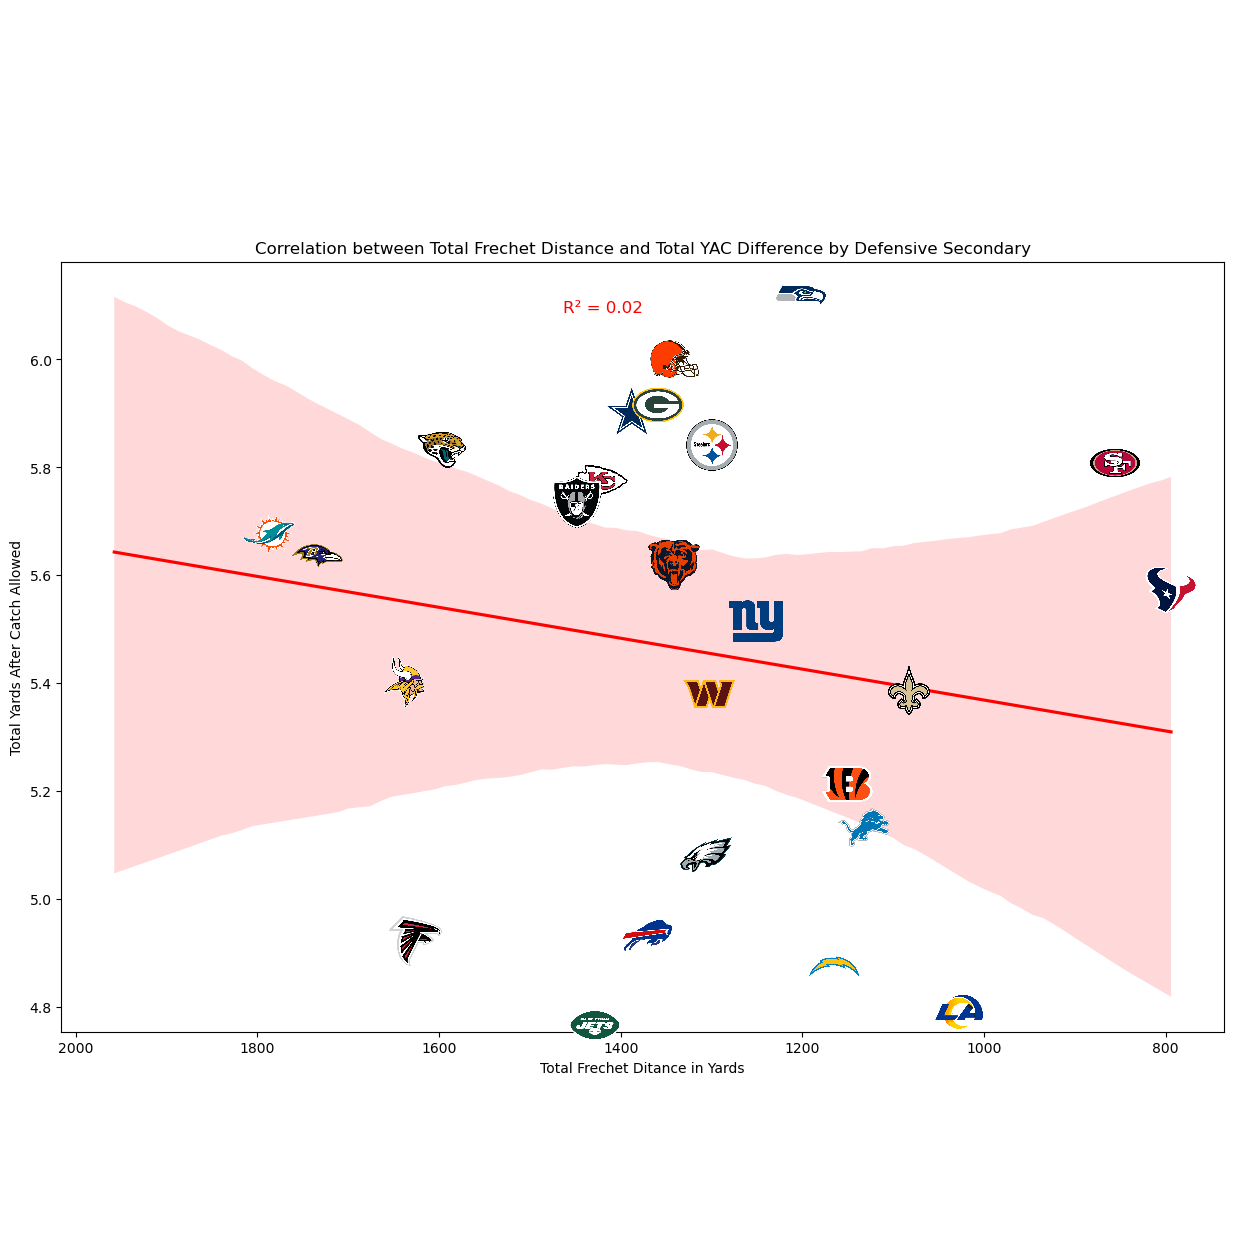

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create the scatter plot with a regression line
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='total_frechet', y='total_yac', data=playfrechet_team_df_with_colors, ax=ax, scatter=False, color='red')

# Invert X and Y axes
ax.invert_xaxis()  # This will show lower frechet distances on the right



# Plot each team with its logo
for index, row in playfrechet_team_df_with_colors.iterrows():
    # Load team logo from URL
    response = requests.get(row['team_logo_espn'])
    img = Image.open(BytesIO(response.content))

    # Convert image to a format suitable for matplotlib
    imagebox = OffsetImage(img, zoom=0.08)
    ab = AnnotationBbox(imagebox, (row['total_frechet'], row['total_yac']), frameon=False)
    ax.add_artist(ab)

# Set labels and title
ax.set_xlabel('Total Frechet Ditance in Yards')
ax.set_ylabel('Total Yards After Catch Allowed')
ax.set_title('Correlation between Total Frechet Distance and Total YAC Difference by Defensive Secondary')
ax.text(0.5, 0.95, f'R\u00b2 = {r_value**2:.2f}', ha='right', va='top', transform=ax.transAxes, color='red', fontsize=12)

plt.show()


Stopping here everything below this needs attention 

In [488]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for summed frechet_distance per player per play vs. yac_diff for each defensive team
plt.figure(figsize=(12, 8))
sns.scatterplot(data=team_agg_df, x='frechet_per_player', y='yac_diff', hue='defensiveTeam')
plt.title('Summed Frechet Distance Per Player Per Play vs. YAC Difference by Defensive Team')
plt.xlabel('Summed Frechet Distance Per Player Per Play')
plt.ylabel('YAC Difference')
plt.legend(title='Defensive Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


NameError: name 'team_agg_df' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
import pandas as pd

# Assuming your DataFrame is named completed_passes

# Group by game and play, then sum 'frechet_distance' and take 'yac_diff' for each play
aggregated_df = completed_passes.groupby(['game_id', 'play_id', 'defensiveTeam']).agg({'frechet_distance':'sum', 'yac_diff':'mean'}).reset_index()


In [ ]:
# Count the number of unique 'nflId' per play
player_count = completed_passes.groupby(['game_id', 'play_id'])['nflId'].nunique().reset_index(name='player_count')

# Merge this count with the aggregated_df
merged_df = pd.merge(aggregated_df, player_count, on=['game_id', 'play_id'], how='left')

# Calculate per-player frechet_distance statistics
merged_df['frechet_per_player'] = merged_df['frechet_distance'] / merged_df['player_count']


In [ ]:
merged_df.info()

In [ ]:
merged_df = merged_df.merge(colors_data, left_on = 'defensiveTeam', right_on= 'team_abbr', how='left')

In [ ]:
merged_df.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for frechet_distance per player vs. yac_diff
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='frechet_distance', y='yac_diff')
plt.title('Correlation between YAC Difference Per Play and Frechet Distance Per Play')
plt.xlabel('Frechet Distance Per Play')
plt.ylabel('YAC Difference Expected - Actual Per Play')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for yac_diff below the threshold of 3
filtered_df = merged_df[merged_df['yac_diff'] > -20]

# Calculate the correlation
correlation = filtered_df['frechet_per_player'].corr(filtered_df['yac_diff'])

# Scatter plot for yac_diff vs. frechet_distance per player with the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='yac_diff', y='frechet_per_player')

# Adding the correlation coefficient to the plot
plt.title(f'Correlation between Per-Player Involved in Tackle Frechet Distance and YAC Difference (YAC Diff < 3)\nCorrelation: {correlation:.2f}')
plt.xlabel('YAC Difference')
plt.ylabel('Frechet Distance Per Player Involved in Tackle')

plt.show()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset




# Step 3: Assess the correlation
correlation = completed_passes[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation between YAC difference and Frechet distance: {correlation:.3f}")

# Step 4: Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=completed_passes, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset

# Step 1: Filter for completed passes
completed_passes = merged_data[merged_data['passResult'] == 'C']

# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
completed_passes['yac_diff'] = completed_passes['yards_after_catch'] - completed_passes['xyac_mean_yardage']

# Step 3: Define a threshold for low unexpected YAC and filter
# Let's say we define "significantly lower" as at least 3 yards less than expected
threshold = 3
low_unexpected_yac = completed_passes[completed_passes['yac_diff'] <= threshold]

# Step 4: Assess the correlation in this subset
correlation = low_unexpected_yac[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation in low unexpected YAC subset: {correlation:.3f}")

# Step 5: Create a scatter plot for this subset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_unexpected_yac, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance in Low Unexpected YAC Subset')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()


In [ ]:
merged_data.columns

In [ ]:
merged_data
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
merged_data['yac_diff'] = merged_data['yards_after_catch'] - merged_data['xyac_mean_yardage']

In [ ]:
# Define the conditions
conditions = ['is_screen_pass', 'is_contested_ball', 'is_play_action', 'yac_diff']

# Initialize a dictionary to store the results
results = {}

for condition in conditions:
    if condition != 'yac_diff':
        # Filter based on the condition
        filtered_df = merged_data[merged_data[condition] == True]
    else:
        # Use the entire DataFrame for yac_diff condition
        filtered_df = merged_data

    # Ensure the DataFrame is not empty
    if not filtered_df.empty:
        # Sort and find the plays with the highest and lowest frechet distances
        highest_frechet = filtered_df.sort_values(by='play_frechet', ascending=False).head(1)
        lowest_frechet = filtered_df.sort_values(by='play_frechet', ascending=True).head(1)

        results[condition] = {
            'highest_frechet': highest_frechet[['week', 'game_id', 'play_id', 'play_frechet']],
            'lowest_frechet': lowest_frechet[['week', 'game_id', 'play_id', 'play_frechet']]
        }

        # For yac_diff condition, also find the highest and lowest yac_diff
        if condition == 'yac_diff':
            top_yac_diff = filtered_df.sort_values(by='yac_diff', ascending=False).head(1)
            lowest_yac_diff = filtered_df.sort_values(by='yac_diff', ascending=True).head(1)

            results[condition].update({
                'top_yac_diff': top_yac_diff[['week', 'game_id', 'play_id', 'yac_diff']],
                'lowest_yac_diff': lowest_yac_diff[['week', 'game_id', 'play_id', 'yac_diff']]
            })

# Print the results
for condition, data in results.items():
    print(f"Condition: {condition}")
    print("Highest Frechet:\n", data['highest_frechet'])
    print("Lowest Frechet:\n", data['lowest_frechet'])
    if condition == 'yac_diff':
        print("Top YAC Diff:\n", data['top_yac_diff'])
        print("Lowest YAC Diff:\n", data['lowest_yac_diff'])
    print("\n")

In [ ]:
test_df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/specific_plays_paths.csv')

In [ ]:
# Assuming test_df is your DataFrame
print("Number of unique Play IDs:", merged_data['play_id'].nunique())
print("Number of unique Games:", merged_data['game_id'].nunique())


In [ ]:
# Group by 'playId' and count unique 'nflId's in each group
unique_nfl_ids_per_play = test_df.groupby('playId')['nflId'].nunique()

# Calculate the average number of unique 'nflId's per play
average_nfl_ids_per_play = unique_nfl_ids_per_play.mean()

print("Average number of unique NFL IDs per play:", average_nfl_ids_per_play)


In [ ]:
# Group by 'playId' and count unique 'frameId's in each group
unique_frames_per_play = test_df.groupby('playId')['frameId'].nunique()

# Calculate the average number of unique frames per play
average_frames_per_play = unique_frames_per_play.mean()

print("Average number of unique frames per play:", average_frames_per_play)



In [ ]:
test_df.info()